In [2]:
def getDist(cord1,cord2):
	return (
		(float(cord1[0])-float(cord2[0]))**2+
		(float(cord1[1])-float(cord2[1]))**2+
		(float(cord1[2])-float(cord2[2]))**2)**0.5 * 10

class gro:    # ndx = {chineID : (start atomNdx, end atomNdx)}
    def __init__(self, groFile):
        from tqdm import tqdm
        self.version = "groObj V.1"
        self.type = "Multi Chains"
        with open(groFile, "r") as gro:
            groLines = gro.readlines()
            self.atomNum = groLines[1]
        self.frames = {} # { frameNdx : { atomNdx : { resNdx : x, coord : (x, y, x) } } }
        frameNdx = 0
        atomDic = {}
        resNdx = groLines[2].split()[:-3]
        for line in tqdm(groLines[2:]):
            line_list = line.split()
            if len(line_list) == 3:
                self.frames[frameNdx] = atomDic
                frameNdx = frameNdx + 1
                atomDic = {}
            elif "Title" not in line and len(line.split()) > 3:
                #print(line)
                atomNdx = int(line.split()[2])
                atomDic[atomNdx] = {
                    "resNdx" : int(line.split()[0][:-3]),
                    "coord" : (
                        float(line.split()[3]),
                        float(line.split()[4]),
                        float(line.split()[5])
                    )
                }
    def getRes(self, ndx):
      frameDic = {} # { frameNdx : { resNdx : { atomNdx : (coord) } } }
      for frame in self.frames.items():# { frameNdx : { atomNdx : { resNdx : x, coord : (x, y, x) } } }
          frameNdx = frame[0]
          atomDic = frame[1]
          resDic = {}
          for atomNdx in range(ndx[0], ndx[1]+1):
              resNdx = atomDic[atomNdx]["resNdx"]
              coord = atomDic[atomNdx]["coord"]
              if resNdx not in list(resDic.keys()):
                  resDic[resNdx] = [coord]
              else:
                  resDic[resNdx].append(coord)
          frameDic[frameNdx] = resDic
      return frameDic

def contactPerFrame(frameNdx, proAtomNdx, ligAtomNdx, groObj):
    with open(groObj, "rb") as groDataFile:
        groData = pickle.load(groDataFile)
    ligRes = groData.getRes(ligAtomNdx)[frameNdx]
    proRes = groData.getRes(proAtomNdx)[frameNdx]
    #print(proRes[15])
    distDic = {}
    ligCoords = []
    for coord in ligRes.items():
        ligCoords = ligCoords + coord[1]
    
    for resID in proRes.keys():
        tmpDislist = []
        for resCoords in proRes[resID]:
            for ligCoord in ligCoords:
                #print(resAtom)
                tmpDislist.append(
                    getDist(resCoords, ligCoord)
                )
        distDic[resID] = round(min(tmpDislist), 3)
    #print(distDic)
    distDic["frameNdx"] = frameNdx
    dataFrame = pd.DataFrame([distDic])
    return dataFrame


In [3]:
groData = gro("../3_md/fit.gro")
import pickle
with open("groData.pkl", "wb") as groDataFile:
    pickle.dump(groData, groDataFile)

100%|██████████| 3194189/3194189 [00:22<00:00, 141336.84it/s]


In [4]:
import pandas as pd
import pickle

frameNdx = 0
proAtomNdx = (1, 2863)
ligAtomNdx = (2864, 3188)
contactPerFrame(frameNdx, proAtomNdx, ligAtomNdx, "groData.pkl")


,15,16,17,18,19,20,21,22,23,24,...,185,186,187,188,189,190,191,192,193,frameNdx
0,11.877,12.262,10.095,3.724,1.968,8.524,8.63,1.62,6.301,2.04,...,13.514,5.676,13.391,10.82,15.484,19.145,15.446,12.855,15.231,0


In [5]:
import pickle
import pandas as pd
from tqdm import tqdm
#print("> loading data")
#with open("groData.pkl", "rb") as groDataFile:
#    groData = pickle.load(groDataFile)
#print("> loaded data")
#for item in groData.frames[1000][15].items():
#    print(item)
from joblib import Parallel, delayed
print("> joblib imported")
proAtomNdx = (1, 2863)
ligAtomNdx = (2864, 2936)
print("> startting multiProcessing")
results = Parallel(
    n_jobs=64, backend='multiprocessing'
    )(delayed(contactPerFrame)(frameNdx, proAtomNdx, ligAtomNdx, "groData.pkl") for frameNdx in tqdm(range(0,1001)))
print("> multiProcessing done")
results = pd.concat(results, axis=0, ignore_index=True)
results = results.sort_values(by=results.columns[-1], ascending=True)
with open("con_results.pkl", "wb") as con_results:
    pickle.dump(results, con_results)
print("> done")

> joblib imported
> startting multiProcessing


100%|██████████| 1001/1001 [13:09<00:00,  1.27it/s]


> multiProcessing done
> done


In [6]:
import pickle
import pandas as pd
with open("con_results.pkl", "rb") as con_results:
    results = pickle.load(con_results)
(results)

,15,16,17,18,19,20,21,22,23,24,...,185,186,187,188,189,190,191,192,193,frameNdx
0,18.092,15.450,12.770,9.986,4.962,10.487,10.677,5.653,6.301,2.040,...,13.514,5.676,13.391,10.820,15.484,19.145,15.446,12.855,15.231,0
1,16.987,14.577,11.516,8.738,4.011,9.640,10.068,4.832,6.457,2.602,...,13.374,5.700,13.886,10.689,14.733,15.940,12.094,11.117,11.619,1
2,15.859,14.596,11.817,8.761,4.257,9.289,10.443,5.487,6.293,2.642,...,13.088,5.330,13.799,11.032,15.473,15.121,11.662,11.072,10.566,2
3,16.770,15.086,12.139,9.108,4.910,9.596,10.132,5.251,6.177,2.689,...,13.683,5.739,14.327,11.547,17.005,15.718,13.610,12.415,11.630,3
4,16.696,14.746,11.975,8.969,4.650,9.759,10.743,6.035,6.629,2.299,...,12.788,5.079,13.211,10.140,15.526,16.420,12.827,11.415,11.642,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,12.536,14.482,11.518,8.317,4.150,9.692,10.590,4.606,6.646,2.642,...,13.246,5.401,14.262,10.671,16.613,20.100,20.609,25.327,24.877,996
997,12.806,14.034,11.117,8.008,3.939,9.610,10.830,5.221,6.433,3.092,...,12.760,5.164,13.420,9.696,16.304,20.037,19.648,24.597,25.307,997
998,12.305,14.397,11.697,8.553,4.042,9.160,10.105,4.836,5.956,2.706,...,14.509,6.867,14.367,11.569,18.207,21.819,20.388,26.739,26.462,998
999,12.558,15.041,11.709,8.489,3.923,9.804,10.697,5.154,5.983,2.563,...,13.759,6.216,14.403,11.285,17.950,21.202,19.769,25.628,25.664,999


In [7]:
heatDat = results.iloc[:, :-1].T
heatDat

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
15,18.092,16.987,15.859,16.770,16.696,17.256,17.476,18.420,18.143,18.846,...,12.757,13.894,12.755,13.500,11.598,12.536,12.806,12.305,12.558,12.538
16,15.450,14.577,14.596,15.086,14.746,14.871,15.385,15.029,15.148,15.591,...,15.062,15.520,14.615,14.718,13.562,14.482,14.034,14.397,15.041,14.647
17,12.770,11.516,11.817,12.139,11.975,12.374,12.453,12.276,12.029,12.588,...,12.576,12.281,11.979,11.675,11.707,11.518,11.117,11.697,11.709,12.215
18,9.986,8.738,8.761,9.108,8.969,8.196,8.918,9.294,9.246,8.667,...,9.265,9.600,9.072,8.699,8.827,8.317,8.008,8.553,8.489,9.526
19,4.962,4.011,4.257,4.910,4.650,4.753,5.343,5.066,4.821,4.998,...,4.248,4.333,4.470,3.987,3.856,4.150,3.939,4.042,3.923,4.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,15.484,14.733,15.473,17.005,15.526,15.040,16.625,16.087,12.904,13.761,...,15.809,16.182,16.277,17.647,15.456,16.613,16.304,18.207,17.950,17.479
190,19.145,15.940,15.121,15.718,16.420,15.507,14.578,12.438,11.889,11.741,...,19.518,19.668,19.596,21.103,19.047,20.100,20.037,21.819,21.202,20.822
191,15.446,12.094,11.662,13.610,12.827,12.462,14.643,14.383,12.747,14.657,...,19.105,19.723,19.820,20.147,18.037,20.609,19.648,20.388,19.769,20.307
192,12.855,11.117,11.072,12.415,11.415,11.277,12.876,11.943,9.315,10.988,...,23.527,24.055,24.384,26.316,23.257,25.327,24.597,26.739,25.628,25.503


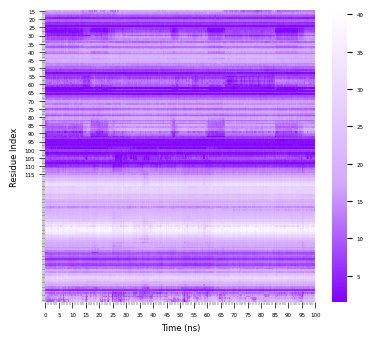

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

df = pd.DataFrame(heatDat)

# 创建自定义颜色映射
# 5以下颜色越小越深，大于等于5的白色
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, "#8000FF"), (0.4, "#D3A7FF"), (1, "#ffffff")],
    N=512
)
#norm = mcolors.Normalize(vmin=0, vmax=5)
#cbar_kws={'ticks': []}

# 绘制热图
fig, ax = plt.subplots(figsize=(4, 3.5) )  # 设置图形大小
sns.heatmap(df, annot=False, cmap=cmap)#, norm=norm, fmt=".1f", cbar_kws=cbar_kws)  # 设置颜色条的标签
plt.yticks([x+0.5 for x in range(0, 101, 5)], range(15, 116, 5))
plt.xticks([x for x in range(0,1001,50)],[ x for x in range(0,101,5)],rotation=0)
ax.tick_params(axis="y",reset=True, which="both", direction="out", width=0.5, length=4,labelsize=4,right=False)
ax.tick_params(axis="y", which="minor",reset=True, direction="out", width=0.3, length=2,zorder=1,right=False)
ax.tick_params(axis="x", which="major", direction="out", width=0.5, length=4, right=False,labelsize=4)
ax.tick_params(axis="x", which="minor", direction="out", width=0.3, length=2, right=False)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
#for i in range(0, 100, 1):
#    ax.axhline(i, color='grey',linewidth=0.1)
    #ax2.axvline(i, color='black',linewidth=0.2)

#plt.text(1115, 17,'d > 5Å', fontsize=4, rotation=-90)
#plt.text(1115, 46,'5Å ≥ d > 4Å', fontsize=4, rotation=-90)
#plt.text(1115, 71,'4Å ≥ d > 3Å', fontsize=4, rotation=-90)
#plt.text(1115, 92,'3Å ≥ d', fontsize=4, rotation=-90)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=4)  # 设置颜色条刻度的字体大小

plt.tight_layout(pad=1.5)
plt.ylabel("Residue Index", fontsize=6)
plt.xlabel("Time (ns)", fontsize=6)
plt.savefig("HeatMap.png", dpi=600)
plt.savefig("HeatMap.svg", dpi=600)
plt.show()


In [9]:
heatDat.iloc[0:101,:]

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
15,18.092,16.987,15.859,16.770,16.696,17.256,17.476,18.420,18.143,18.846,...,12.757,13.894,12.755,13.500,11.598,12.536,12.806,12.305,12.558,12.538
16,15.450,14.577,14.596,15.086,14.746,14.871,15.385,15.029,15.148,15.591,...,15.062,15.520,14.615,14.718,13.562,14.482,14.034,14.397,15.041,14.647
17,12.770,11.516,11.817,12.139,11.975,12.374,12.453,12.276,12.029,12.588,...,12.576,12.281,11.979,11.675,11.707,11.518,11.117,11.697,11.709,12.215
18,9.986,8.738,8.761,9.108,8.969,8.196,8.918,9.294,9.246,8.667,...,9.265,9.600,9.072,8.699,8.827,8.317,8.008,8.553,8.489,9.526
19,4.962,4.011,4.257,4.910,4.650,4.753,5.343,5.066,4.821,4.998,...,4.248,4.333,4.470,3.987,3.856,4.150,3.939,4.042,3.923,4.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,8.616,8.615,8.864,9.338,8.308,8.276,9.024,8.899,8.801,9.606,...,9.250,9.152,9.244,9.863,9.646,9.723,9.332,9.774,10.196,9.357
112,12.318,12.583,12.779,13.158,11.905,12.150,12.820,12.646,12.844,13.432,...,13.068,13.045,13.066,13.690,13.598,13.555,13.149,13.362,13.735,13.190
113,13.195,14.261,14.166,14.972,12.944,13.407,13.537,13.793,13.250,14.103,...,14.094,13.618,13.798,14.564,14.149,14.401,13.628,14.538,14.693,14.220
114,13.572,13.735,13.521,13.739,13.036,14.008,13.079,14.014,13.201,13.410,...,13.476,13.209,13.141,13.784,13.488,13.719,12.740,13.876,14.218,13.278


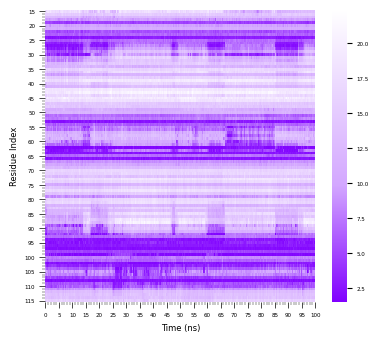

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

df = pd.DataFrame(heatDat.iloc[0:101,:])

# 创建自定义颜色映射
# 5以下颜色越小越深，大于等于5的白色
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0, "#8000FF"), (0.4, "#D3A7FF"), (1, "#ffffff")],
    N=512
)
#norm = mcolors.Normalize(vmin=0, vmax=5)
#cbar_kws={'ticks': []}

# 绘制热图
fig, ax = plt.subplots(figsize=(4, 3.5) )  # 设置图形大小
sns.heatmap(df, annot=False, cmap=cmap)#, norm=norm, fmt=".1f", cbar_kws=cbar_kws)  # 设置颜色条的标签
plt.yticks([x+0.5 for x in range(0, 101, 5)], range(15, 116, 5))
plt.xticks([x for x in range(0,1001,50)],[ x for x in range(0,101,5)],rotation=0)
ax.tick_params(axis="y",reset=True, which="both", direction="out", width=0.5, length=4,labelsize=4,right=False)
ax.tick_params(axis="y", which="minor",reset=True, direction="out", width=0.3, length=2,zorder=1,right=False)
ax.tick_params(axis="x", which="major", direction="out", width=0.5, length=4, right=False,labelsize=4)
ax.tick_params(axis="x", which="minor", direction="out", width=0.3, length=2, right=False)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
#for i in range(0, 100, 1):
#    ax.axhline(i, color='grey',linewidth=0.1)
    #ax2.axvline(i, color='black',linewidth=0.2)

#plt.text(1115, 17,'d > 5Å', fontsize=4, rotation=-90)
#plt.text(1115, 46,'5Å ≥ d > 4Å', fontsize=4, rotation=-90)
#plt.text(1115, 71,'4Å ≥ d > 3Å', fontsize=4, rotation=-90)
#plt.text(1115, 92,'3Å ≥ d', fontsize=4, rotation=-90)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=4)  # 设置颜色条刻度的字体大小

plt.tight_layout(pad=1.5)
plt.ylabel("Residue Index", fontsize=6)
plt.xlabel("Time (ns)", fontsize=6)
plt.savefig("HeatMap.png", dpi=600)
plt.savefig("HeatMap.svg", dpi=600)
plt.show()
